<a href="https://colab.research.google.com/github/sogangori/choongang20/blob/master/SVHN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

미션 :
- 데이터획득: .mat 에서 x, y 를 가져옵니다
- 전처리 :  x, y 를 학습할 수 있게 만듭니다
   - x : (h,w,c,m) > (m,h,w,c) 로 수정
   - y : (m,1) > (m) 로 수정
     - y 의 라벨을 확인하세요. 숫자 0 의 라벨이 '10'입니다. 이것을 0으로 수정하세요
- 모델 생성: CNN, RNN, CRNN 등의 모델을 만듭니다
- 학습 및 평가: 데이터를 학습시키고 성능을 측정합니다

In [1]:
%tensorflow_version 2.0x
import tensorflow as tf
from tensorflow import keras
from google.colab import files

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.0x`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [3]:
# 구글 드라이브에 파일을 업로드해두고 읽는 방식
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [5]:
mat = loadmat('test_32x32.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [6]:
# 데이터 획득
x = mat['X']
y = mat['y']
x.shape, y.shape

((32, 32, 3, 26032), (26032, 1))

In [7]:
# 전처리
x = np.transpose(x, [3,0,1,2])/255
y = y[:, 0]
x.shape, y.shape, np.max(x)

((26032, 32, 32, 3), (26032,), 1.0)

In [8]:
# y 에서 10값을 0으로 바꾸기
y = np.where(y > 9, 0, y)
set(y)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [0]:
m = len(y)//2
x_train = x[:m]
y_train = y[:m]
x_test = x[m:m*2]
y_test = y[m:m*2]

In [0]:
def attach_3_image(x, y):
  #영상을 좌우로 붙여서 3자리수 데이터를 만듭니다 x (m,h,w,c), y (m) 
  m = len(y)
  m = m - m % 3 
  x, y = x[:m], y[:m]# 3의 배수의 데이터수 사용    
  pad = 6
  x = x[:, :, pad:-pad]#영상 좌우 6 px 제거
  x_attach = np.concatenate((x[::3], x[1::3], x[2::3]), axis=2)
  y_attach = np.reshape(y, [-1, 3])
  return x_attach, y_attach

In [11]:
x3_train, y3_train = attach_3_image(x_train, y_train)
x3_test, y3_test = attach_3_image(x_test, y_test)
x3_train.shape, y3_train.shape, x3_test.shape, y3_test.shape

((4338, 32, 60, 3), (4338, 3), (4338, 32, 60, 3), (4338, 3))

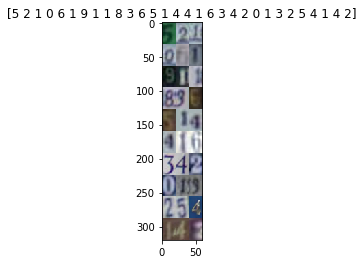

In [12]:
i = 0
n = 10
m,h,w,c = x3_train.shape
plt.title(str(y3_train[i:i+n].reshape([-1])))
#sample = np.transpose(x3_train[i:i+n], [1,0,2,3]).reshape((h,-1,c))
sample = x3_train[i:i+n].reshape((-1,w,c))
plt.imshow(sample)

![CNN 모델](http://ww4.sinaimg.cn/large/006tNbRwgw1fawztq64xuj30ib0d1wf8.jpg)

In [0]:
class MyModel(keras.Model): # github.com/sogangori/choongang20/ 
  def __init__(self):    
    super(MyModel, self).__init__()
    self.k = 10
    self.seq = 3
    self.opt = tf.optimizers.RMSprop(learning_rate=0.01)
    self.conv0 = keras.layers.Conv2D(16, [3,3], padding='same', activation=keras.activations.relu)
    self.conv1 = keras.layers.Conv2D(16, [3,3], padding='same', activation=keras.activations.relu)
    self.conv2 = keras.layers.Conv2D(16, [3,3], padding='same', activation=keras.activations.relu)
    self.conv3 = keras.layers.Conv2D(16, [3,3], padding='same', activation=keras.activations.relu)
    self.pool = keras.layers.MaxPool2D([2,2], padding='same')
    self.flatten = keras.layers.Flatten()
    self.dense = keras.layers.Dense(units=self.k*self.seq)
  
  def call(self, x):
    x = tf.cast(x, tf.float32)
    net = self.conv0(x)
    net = self.pool(net)
    net = self.conv1(net)
    net = self.pool(net)
    net = self.conv2(net)
    net = self.pool(net)
    net = self.conv3(net)
    net = self.pool(net)
    net = self.flatten(net)    
    h = self.dense(net)
    h = tf.reshape(h, [-1, self.seq, self.k])
    h = tf.nn.softmax(h, axis=-1)
    return h

  def get_loss(self, y, h):
    #학습할때 nan이 발생하는 경우 값을 clip(자르다) (최소값, 최대값) 
    h = tf.clip_by_value(h, 1e-6, 1 - 1e-6) # h 가 0이나 1이 되지 않도록 하는 안전장치 
    #cross_entropy = - (y * tf.math.log(h) + (1 - y) * tf.math.log(1 - h)) 
    cross_entropy = - (y * tf.math.log(h)) #좌측항만 사용해도 학습 가능
    loss = tf.reduce_mean(cross_entropy)
    w_mean = [(tf.reduce_mean(tf.square(w))) for w in self.trainable_variables]
    loss_regularization = tf.reduce_mean(w_mean)#weight 가 커지지 않도록 제한하는 로스
    return loss + 0.0001 * loss_regularization

  def get_accuracy(self, y, h):    
    predict = tf.argmax(h, -1)
    is_equal = tf.equal(y, predict)
    acc = tf.reduce_mean(tf.cast(is_equal, tf.float32)) # True > 1, False > 0 로 cast
    acc_all = tf.reduce_mean(tf.cast(tf.reduce_all(is_equal, axis=1), tf.float32))
    return acc, acc_all

  def fit(self, x, y, epoch=1, batch_m=100):    
    for i in range(epoch):#학습 횟수
      iteration = (len(y)-1)//batch_m + 1
      for j in range(iteration):#배치 갯수
        start = j * batch_m
        end = (j+1) * batch_m
        x_batch = x[start:end]
        y_batch = y[start:end]
        y_hot = tf.one_hot(y_batch, depth=self.k, axis=-1)
        with tf.GradientTape() as tape: #경사 기록 장치
          h = self.call(x_batch)
          loss = self.get_loss(y_hot, h)         
        grads = tape.gradient(loss, self.trainable_variables) #경사 계산
        #경사가 너무 크면 nan 이 될 수 있으므로 gradient cliping (최소,최대값 제한) 을 합니다
        grads = [(tf.clip_by_value(grad, -8.0, 8.0)) for grad in grads]      
        self.opt.apply_gradients(zip(grads, self.trainable_variables)) # 가중치에서 경사를 빼기
        acc, acc_all = self.get_accuracy(y_batch, h)

        if j==0:
          print('%d/%d loss:%.3f acc:(%.3f all:%.3f)'%(i, epoch, loss, acc, acc_all))
model = MyModel()

In [20]:
model.fit(x3_train[:1000], y3_train[:1000], epoch=100)

0/100 loss:0.232 acc:(0.083 all:0.000)
1/100 loss:0.226 acc:(0.217 all:0.000)
2/100 loss:0.224 acc:(0.223 all:0.010)
3/100 loss:0.221 acc:(0.223 all:0.010)
4/100 loss:0.220 acc:(0.223 all:0.010)
5/100 loss:0.221 acc:(0.193 all:0.000)
6/100 loss:0.221 acc:(0.223 all:0.010)
7/100 loss:0.220 acc:(0.223 all:0.010)
8/100 loss:0.220 acc:(0.227 all:0.010)
9/100 loss:0.219 acc:(0.217 all:0.020)
10/100 loss:0.220 acc:(0.207 all:0.020)
11/100 loss:0.219 acc:(0.183 all:0.010)
12/100 loss:0.215 acc:(0.230 all:0.020)
13/100 loss:0.214 acc:(0.243 all:0.030)
14/100 loss:0.211 acc:(0.253 all:0.030)
15/100 loss:0.211 acc:(0.270 all:0.010)
16/100 loss:0.210 acc:(0.270 all:0.020)
17/100 loss:0.209 acc:(0.263 all:0.030)
18/100 loss:0.209 acc:(0.300 all:0.020)
19/100 loss:0.209 acc:(0.270 all:0.010)
20/100 loss:0.203 acc:(0.307 all:0.020)
21/100 loss:0.199 acc:(0.297 all:0.030)
22/100 loss:0.197 acc:(0.307 all:0.020)
23/100 loss:0.194 acc:(0.303 all:0.020)
24/100 loss:0.189 acc:(0.353 all:0.040)
25/100 los

In [21]:
h = model(x3_test)
acc, acc_all = model.get_accuracy(y3_test, h)
print('개별정확도',acc.numpy(), '이미지별 정확도',acc_all.numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

개별정확도 0.29183957 이미지별 정확도 0.024204703
